## Table of Contents

1. [Problem Statement](#1.-Problem-Statement)
2. [Data](#2.-Data:-Google-Local-Data-(2021))
3. [EDA & Data Preprocessing](#3.-EDA-&-Data-Preprocessing)
4. [Modeling Approach](#4.-Modeling-Approach)
    - [4.1 Baseline Model](#4.1-Baseline-Model)
    - [4.2 Collaborative Filtering: Restaurant Similarities by Meta-Data](#)
    - [4.3 Collaborative Filtering: User Similarities by Review Text Embeddings](#)
        - [4.2.1 Word2Vec](#4.2.1-Word2Vec)
        - [4.2.2 Bag of Words](#4.2.2-Bag-of-Words)
        - [4.2.3 Latent Dirichlet Allocation (LDA)](#4.2.3-Latent-Dirichlet-Allocation-(LDA))
        - [4.2.4 Large Language Model (BERT)](#4.2.4-Large-Language-Model-(BERT))
        - [4.2.5 Large Language Model (Fine-tuned DistilledBert)](#4.2.5-Large-Language-Model-(BERT))
        - [4.2.6 Large Language Model (Fine-tuned Sentence Transformer)](#4.2.6-Large-Language-Model-(BERT))
5. [Results](#5.-Results)
6. [Conclusion](#6.-Results)
7. [Future Work](#7.-Future-Work)

---


# 1. Problem Statement

* **Background:** Deciding where to eat can often lead to indecision among diners. This is influenced by a multitude of factors including personal preferences, past dining experiences, and reviews from other diners.

* **Objective:** 
    * Understand the impact of geographical location, price, and review volume on consumer ratings.
    * Develop a **recommendation system** that leverages natural language processing (NLP) and sentiment analysis to recommend restaurants based on personalized consumer preferences and reviews.

* **Impact:**
    * **Enhanced Decision Making:** Provide diners with personalized restaurant recommendations based on analyzed sentiments.
    * **Business Insights:** Offer restaurants actionable insights on consumer preferences and areas for improvement based on sentiment analysis.

# 2. Data: Google Local Data (2021)

**Citation**

**UCTopic: Unsupervised Contrastive Learning for Phrase Representations and Topic Mining**  
Jiacheng Li, Jingbo Shang, Julian McAuley  
*Annual Meeting of the Association for Computational Linguistics (ACL)*, 2022  
[pdf](https://aclanthology.org/2022.acl-long.426.pdf)


**Personalized Showcases: Generating Multi-Modal Explanations for Recommendations**  
An Yan, Zhankui He, Jiacheng Li, Tianyang Zhang, Julian Mcauley  
*The 46th International ACM SIGIR Conference on Research and Development in Information Retrieval (SIGIR)*, 2023  
[pdf](https://arxiv.org/pdf/2207.00422.pdf)

**Data Source**

The Google Local Dataset offers a comprehensive collection from Google Local (Google Maps), featuring 4 million restaurants and over 600 million reviews, along with 4.43 million images posted by approximately 100 million users. It contains detailed information such as geographical location, business category,
opening status, price levels, and average ratings for each restaurant. This multi-modal dataset
includes textual reviews, user-generated images, and various metadata attributes, providing a
comprehensive foundation for analyzing consumer preferences and behaviors in the context of
restaurant recommendations.

For our project, we decided to focus on the resturants in Massachusetts, which includes 5,624,944 reviews and 92,520 businesses in metadata.

*Massachusetts 10-cores Review Dataset*
(https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/)

*Masechusetts Metadata*
(https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/)

# 3. EDA & Data Preprocessing 

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from copy import deepcopy
from sklearn.model_selection import train_test_split
from utility import is_english, get_emoji_pattern, merge_df
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

RERUN_PREPROCESSING = False

In [2]:
review_ma = pd.read_json('data/review-Massachusetts_10.json', lines=True)
metadata_ma = pd.read_json('data/meta-Massachusetts.json', lines=True)

# Filter out restaurants based on business category
restaurant_ma = metadata_ma[metadata_ma['category'].apply(lambda x: 'Restaurant' in x if isinstance(x, list) else False)]

# Drop duplicated rows
review_ma = review_ma.drop_duplicates(subset=['user_id', 'name', 'time', 'rating', 'text', 'gmap_id'])
restaurant_ma = restaurant_ma.drop_duplicates(subset = ["name", "address", "gmap_id", "url"])

df = pd.merge(review_ma, restaurant_ma, on='gmap_id', how='inner')
df.to_csv("data/data_ma.csv", index=False)

In [3]:
df = pd.read_csv("data/data_ma.csv")
print("Number of restaurant reviews in MA:", len(df))

/var/folders/wh/3zjhqx7s7d747p205gcyh2480000gn/T/ipykernel_29930/277753387.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/data_ma.csv")


Number of restaurant reviews in MA: 1239217


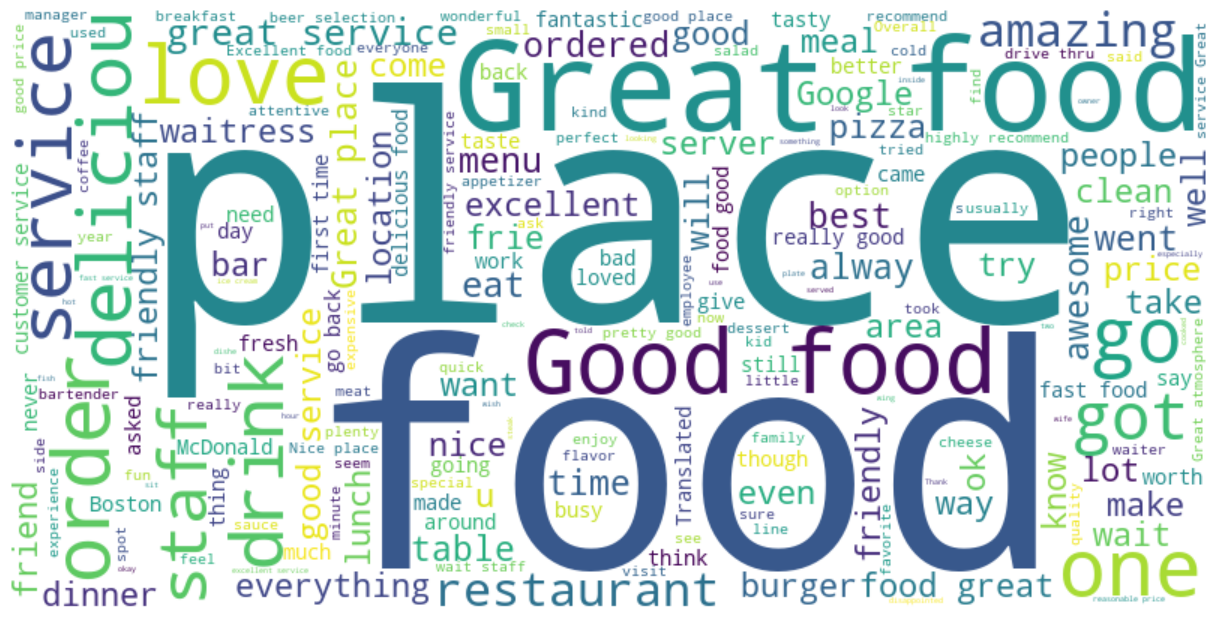

In [4]:
if RERUN_PREPROCESSING:
    all_text = df[-df['text'].isna()].drop_duplicates(subset='text', keep='first').text.to_list()
    
    with open('data/reviews.json', 'w', encoding='utf-8') as file:
        json.dump(all_text, file, ensure_ascii=False, indent=2)

all_text = pd.read_json('data/reviews.json').iloc[:,0].tolist()

wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(' '.join(all_text))
plt.figure(figsize = (12, 6), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

The Word Cloud highlights the following key themes:
1. **Emphasis on Food Quality and Experience:** The largest words, like "good," "food," and "great," indicate that these are the most common descriptors used in reviews. This suggests that the overall quality of food and the dining experience are central to customer feedback.
2. **Service Quality:** The prominence of words such as "service" and "staff" alongside positive terms like "amazing," "excellent," and "friendly" suggests that service quality is a significant factor in customer satisfaction.
3. **Specific Offerings and Descriptors:** The presence of specific food items or attributes, such as "pizza," "burger," "lunch," and "breakfast," shows that customers often comment on particular dishes or meals, indicating standout items or specialties that may draw in patrons.
4. **Emotional Connections:** The use of words like "love" and "favorite" reflects strong emotional connections and personal preferences.



### Keep only English reviews

In [5]:
if RERUN_PREPROCESSING:    
    df_filtered = df[-df['text'].isna()].drop_duplicates(
            subset='text', 
            keep='first'
            # The reviews match data/reviews.json
        )[['user_id', 'gmap_id', 'text', 'rating']]

    english_mask = df['text'].apply(is_english)

    df_filtered = df_filtered[english_mask]
    df_filtered.to_csv("data/english_reviews.csv", index=False)

### Remove emoji

In [2]:
# If RERUN_PREPROCESSING is False, start here
df_filtered = pd.read_csv("data/english_reviews.csv")

emoji_pattern = get_emoji_pattern()

has_emoji = df_filtered.text.apply(lambda x: bool(emoji_pattern.search(x)))
print('#Reviews containing emoji:', df_filtered[has_emoji].text.count())

def remove_emoji(df_filtered):
    emoji_pattern = get_emoji_pattern()

    df_filtered['text'] = df_filtered['text'].apply(lambda x: emoji_pattern.sub(r'', x))
    return df_filtered

#Reviews containing emoji: 15685


### Reduce to extract the k-core for text

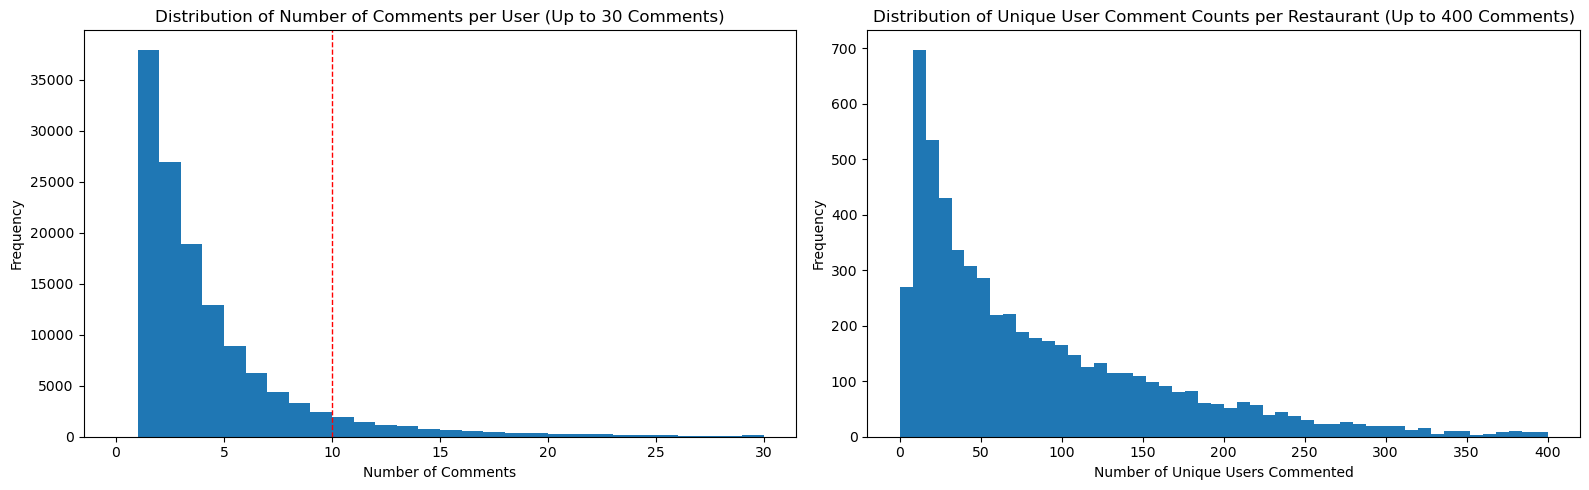

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

comment_counts = df_filtered['user_id'].value_counts()
threshold = 30
axes[0].hist(comment_counts[comment_counts <= threshold], bins=threshold, range=(0, threshold))
axes[0].axvline(x=10, color='r', linestyle='--', linewidth=1)
axes[0].set_title(f'Distribution of Number of Comments per User (Up to {threshold} Comments)')
axes[0].set_xlabel('Number of Comments')
axes[0].set_ylabel('Frequency')
axes[0].grid(False)

restaurant_user_counts = df_filtered.groupby('gmap_id')['user_id'].nunique()
axes[1].hist(restaurant_user_counts[restaurant_user_counts <= 400], bins=50, range=(0, 400))
# axes[1].axvline(x=20, color='r', linestyle='--', linewidth=1)
axes[1].set_title('Distribution of Unique User Comment Counts per Restaurant (Up to 400 Comments)')
axes[1].set_xlabel('Number of Unique Users Commented')
axes[1].set_ylabel('Frequency')
axes[1].grid(False)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

* Distribution of Number of Comments per User (left histogram) shows a steep decline in frequency as the number of comments per user increases. The majority of users leave fewer than 5 comments, and the frequency significantly drops beyond this point.

* Distribution of Unique User Comment Counts per Restaurant (right histogram) also shows a rapid decline, with most restaurants having fewer than 50 unique users who commented. There is a long tail extending towards 400+ unique users, but it includes very few restaurants.

In [59]:
# Count the number of comments per gmap_id
restaurant_comment_counts = df_filtered['gmap_id'].value_counts().reset_index()
restaurant_comment_counts.columns = ['gmap_id', 'comment_count']
if RERUN_PREPROCESSING: 
    df_filtered = df_filtered.merge(restaurant_comment_counts, on='gmap_id', how='left')
    df_filtered.to_csv("data/english_reviews.csv", index=False) #add comment_count into english_reviews.csv

In [60]:
df_filtered = pd.read_csv("data/english_reviews.csv")

# Filter to include only those RESTAURANTs with more than 20 comments
df_filtered = df_filtered[df_filtered['comment_count'] >= 20]

# Filter to include only those USERs with more than 10 comments
users_with_more_threshold = comment_counts[comment_counts >= 10].index
df_filtered = df_filtered[df_filtered['user_id'].isin(users_with_more_threshold)]

# Remove emoji and Replace '\n' or whitespaces with a white space ' '
df_filtered = remove_emoji(df_filtered)
df_filtered['text'] = df_filtered['text'].str.replace('\s+', ' ', regex=True)
concatenated_comments = df_filtered.groupby('user_id')['text'].apply(lambda x: '\n'.join(x))

concatenated_comments.to_csv('data/user_concat_text_10_20.csv', sep=';', index=True)

In [61]:
df_cleaned = merge_df(df_filtered)
df_cleaned.to_csv("data/df_cleaned.csv", index=False)

/Users/mashiyu/Documents/GitHub/Restaurant-Rec-Google-Reviews/utility.py:78: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/data_ma.csv")


/Users/mashiyu/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mashiyu/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mashiyu/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mashiyu/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

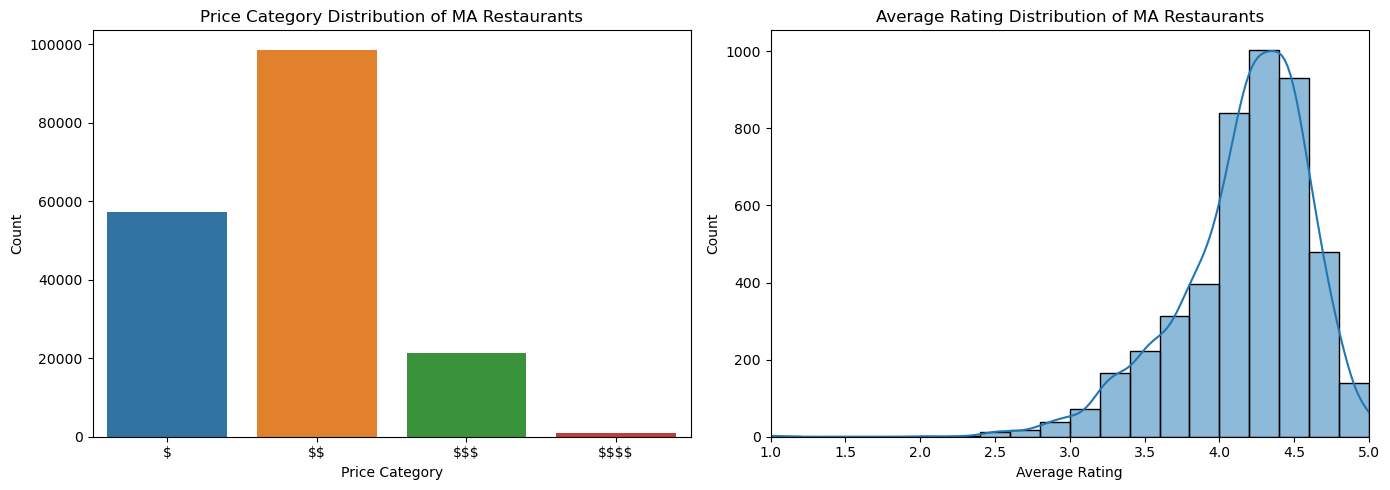

In [62]:
valid_prices = df_cleaned['price'].astype(str)
price_lengths = valid_prices.apply(len)
average_ratings = df_cleaned.groupby('gmap_id')['rating'].mean().reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Plot 1: Price Category Distribution
sns.countplot(x=price_lengths, ax=axes[0])
axes[0].set_title('Price Category Distribution of MA Restaurants')
xticklabels = [r'{}'.format('\$' * p) for p in sorted(price_lengths.unique())]
axes[0].set_xticks(range(len(xticklabels)))
axes[0].set_xticklabels(xticklabels)
axes[0].set_xlabel('Price Category')
axes[0].set_ylabel('Count')

# Plot 2: Average Rating of Restaurants
sns.histplot(average_ratings['rating'], ax=axes[1], bins=20, kde=True)
axes[1].set_title('Average Rating Distribution of MA Restaurants')
axes[1].set_xlabel('Average Rating')
axes[1].set_xlim([1,5])
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

The first chart shows the distribution of restaurants across different price categories, indicating increasing levels of expense, from budget-friendly to high-end dining experiences.
* \$\$ category indicates a moderate price level, and it's clear from the chart that this category encompasses the majority of restaurants. This suggests that **most restaurants in Massachusetts are priced at a mid-range or budget-friendly level**, accessible to a broad segment of the population.

The second chart shows the distribution of average ratings for restaurants, which is crucial for understanding consumer satisfaction:
* The ratings are mostly concentrated around the 4.0 to 4.5 range, indicating that the **majority of restaurants are well-regarded** by customers.
* There's a notable decrease in frequency as ratings approach the lower end of the scale, with very few restaurants rated below 3.0. This pattern suggests that poorly rated restaurants are relatively rare, OR possibly that consumers prefer not to rate rather than leave a low rating.
* The skew towards higher ratings may also reflect a **bias in consumer reporting**, where only motivated, satisfied customers choose to leave reviews.


/Users/mashiyu/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mashiyu/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


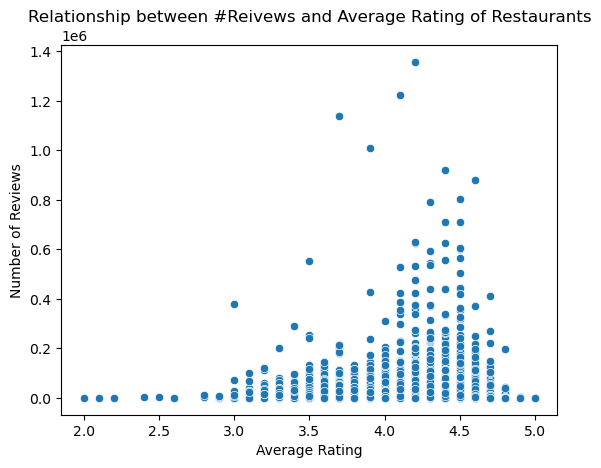

In [63]:
num_reviews_restaurant = df_cleaned.groupby("gmap_id")["num_of_reviews"].sum()
avg_ratings_restaurant = df_cleaned.groupby("gmap_id")["avg_rating"].mean()
sns.scatterplot(x = avg_ratings_restaurant, y = num_reviews_restaurant);
plt.title('Relationship between #Reivews and Average Rating of Restaurants')
plt.xlabel('Average Rating')
plt.ylabel('Number of Reviews')
plt.show()

Key observations from the plot include
1. **Higher Density at Higher Ratings:** The graph shows a clear concentration of data points towards higher ratings, particularly around the 4.0 to 4.5 range. 
2. **Sparse Data at Lower Ratings:** There are fewer restaurants with lower average ratings (2.0 to 3.5), and these establishments also tend to have fewer reviews. This could indicate that restaurants with lower customer satisfaction either receive less feedback overall or are less frequently visited.

This graph provides evidence supporting a potential bias in consumer reporting, as previously indicated by the previous plot of distribution of average ratings


# 4. Modeling Approach

In recommendation system, content-based recommendation and user-based collaborative filtering are the two main approaches. Content-based recommendation systems are suitable when there's rich metadata available for the resteraurant and when user's unique preferences can be inferred from the characteristics of the resteraurants. They are also advantageous when there's a cold-start problem, as they can recommend resteraurants to new users based on resteraurants' features alone.

On the other hand, user-based collaborative filtering is useful when there's sufficient user interaction data available, such as ratings or visit history. It's effective in capturing user preferences based on their interactions with similar users. User-based collaborative filtering works well in scenarios where users have similar tastes, and it can provide recommendations based on other users' behaviors.

We applied the vanilla version of content-based recommendation using XGBoost as our baseline model. Such results rely too much on the average rating and is lack of user preference. To improve the recomendation performance, we tried multiple versions of collaborative filtering based on resteraurants similarities and user similarities, with and without review text embeddings. 

## 4.1 Baseline Model

XGBoost can be a suitable choice for our baseline content-based recommendation model for several reasons:

- Scalability: XGBoost is known for its scalability and efficiency, making it suitable for handling our large datasets.

- Feature importance analysis: XGBoost provides a feature importance analysis, which can help identify the most influential features in making recommendations. This information can be valuable for understanding which restaurant attributes or user preferences have the greatest impact on the recommendations, allowing for more interpretable and insightful models.

- High predictive performance: XGBoost is a powerful ensemble learning algorithm that often achieves high predictive performance. In a recommendation system, accurate predictions are crucial for providing relevant and personalized recommendations to users. XGBoost's ability to capture complex patterns in the data can lead to more accurate recommendations.

Overall, XGBoost's versatility, interpretability, scalability, and predictive performance make it our choice for building baseline content-based recommendation models.

To enhance the efficiency of model prediction in XGBoost, we transform the categorical 'price' column into dummy variables.

In [6]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [7]:
df_cleaned = pd.read_csv("data/df_cleaned.csv")[
        ['user_id', 'name_y', 'rating', 'text', 'gmap_id', 'latitude', 'longitude', 'num_of_reviews', 'price', 'avg_rating']
    ]

In [8]:
print(df_cleaned.isnull().any())
print()
print(f"Percentage of missing review text: {df_cleaned['text'].isna().sum()/len(df_cleaned)*100:.2f}%")
print(f"Percentage of reviews with missing values in 'price' column: {df_cleaned['price'].isna().sum()/len(df_cleaned)*100:.2f}%")

user_id           False
name_y            False
rating            False
text              False
gmap_id           False
latitude          False
longitude         False
num_of_reviews    False
price              True
avg_rating        False
dtype: bool

Percentage of missing review text: 0.00%
Percentage of reviews with missing values in 'price' column: 8.10%


In [9]:
df_cleaned.dropna(inplace=True)
# df_cleaned.price.value_counts()
df_cleaned = df_cleaned[~df_cleaned['price'].isin(['₩₩', '₩', '₩₩₩₩', '₩₩₩'])]
df_cleaned.price.value_counts()


price
$$      96712
$       56808
$$$      6684
$$$$      852
Name: count, dtype: int64

In [10]:
df_cleaned.dropna(inplace=True)
one_hot = pd.get_dummies(df_cleaned['price'])
df_cleaned = pd.concat([df_cleaned, one_hot], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_cleaned.drop(['rating','text','name_y','price','user_id','gmap_id'], axis=1), 
                                                    df_cleaned[['rating']], 
                                                    test_size=0.3, random_state=209)
X_train

,latitude,longitude,num_of_reviews,avg_rating,$,$$,$$$,$$$$
153179,42.423060,-71.007946,2024,4.2,True,False,False,False
112167,42.351219,-71.063121,1198,3.9,True,False,False,False
33904,42.614649,-70.647642,353,4.5,True,False,False,False
27763,42.256585,-71.796780,1094,4.4,False,True,False,False
89367,42.558823,-71.182556,388,4.0,False,True,False,False
...,...,...,...,...,...,...,...,...
141707,42.347500,-71.106000,277,4.5,False,True,False,False
126154,42.366197,-71.090865,863,4.4,False,True,False,False
28310,42.573495,-71.278114,457,4.5,True,False,False,False
136902,42.010979,-70.732723,418,3.3,True,False,False,False


In [11]:
model1 = xgb.XGBRegressor(objective='reg:squarederror')
model1.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [12]:
pred1 = model1.predict(X_test)
# rmse = np.sqrt(np.mean((pred1 - y_test.to_numpy())**2))
mse = mean_squared_error(y_test, pred1)  
rmse = np.sqrt(mse) 
print(f'content-based rmse = {rmse:.4f}')

content-based rmse = 1.0375


In [13]:
feature_importance = pd.DataFrame(model1.feature_importances_, index=X_train.columns, columns=['Importance'])
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance)

                Importance
avg_rating        0.814083
$                 0.030454
$$                0.028128
num_of_reviews    0.028048
longitude         0.027174
$$$               0.026321
latitude          0.023091
$$$$              0.022702


XGBoost mainly depends on the average rating to make predictions since when a new user-restaurant pair appears, the best guess about the user's rating is the average rating of the restaurant. This tells us how the recommendation performance would be if we don't include any user preferences. 

A more sensible approach is when a new user-restaurant pair appears, we check how similar users rated this restaurant or how similar restaurants were rated by this user. Then, we take the average of these ratings weighted by similarity scores as our predicted rating. This is the general idea of the matrix factorization model we applied below. We extract similarities between restaurants and between users respectively and compare their results.

## 4.2 Collaborative Filtering

The goal of Matrix Factorization model is to fill in all the missing values in the users-restraurants rating matrix based on similarities, while keeping all the existing ratings the same. The model achieves this by decomposing the original ratings matrix into two lower-dimensional matrices, typically referred to as the user and item latent factor matrices. These matrices capture underlying patterns and relationships in the data, allowing the model to make accurate predictions for previously unseen user-item pairs. Through iterative optimization algorithms, such as gradient descent, the model learns the latent factors that best represent the users and items, thus enabling personalized recommendations tailored to individual preferences.

Since we need to compute similarities for all users and restaurants to make predictions, we can't remove any users or restaurants completely. So, for train-test split, we take a different approach: we randomly remove ratings in the user-restaurant rating matrix to build our training similarity matrix. This training similarity matrix would be the input of our matrix factorization model to predict ratings of all user-restaurant pairs. Finally, we compare our predicted rating with the ground truth ratings removed by us to compute the difference using RMSE. This ensures our user-restaurant rating matrix always includes all users and restaurants, while preventing data leakage to our model.

In [64]:
utility = df_cleaned.pivot_table(index = 'gmap_id', columns = 'user_id', values = 'rating', aggfunc='mean')
utility = utility.fillna(0)
utility #ground truth: restaurant-user rating matrix

user_id,1.00001815542405e+20,1.0000196381652143e+20,1.0000267380324078e+20,1.000030211813017e+20,1.0000574885556987e+20,1.0000585351141774e+20,1.0000806981591043e+20,1.000084189283105e+20,1.0001011223140635e+20,1.0001122471246196e+20,...,1.1842482504266985e+20,1.1842509012944282e+20,1.1842766775908313e+20,1.1842988152420413e+20,1.1843200755168652e+20,1.1843823779296594e+20,1.1844007788627432e+20,1.1844334502681656e+20,1.1844490020788996e+20,1.18446064332946e+20
gmap_id,,,,,,,,,,,,,,,,,,,,,
0x405c5a74b3440383:0xa36c9c1781e4be1f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x405c713b78073d69:0x44e973b04b0fa378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x405d7d631ff16add:0x9bed826678184414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x405da83bbc3429bf:0x7b0a2daaa5c78907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x864819503264d297:0x2b4de82586d8bfef,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x89fca77e63bf1171:0xfe805276d1a642b7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x89fca77e64092027:0x5b5e11468208ad02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x89fca77e7dd46023:0x5a13b696296b8553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0


In [65]:
def create_train_set(ground_truth, replace_ratio=0.3, random_seed=209):

    ori_values = ground_truth.values.reshape(-1,1)
    nonzero_indices = np.nonzero(ori_values)[0]
    num_values_to_replace = int(replace_ratio * len(nonzero_indices))

    np.random.shuffle(nonzero_indices)
    replace_indices = nonzero_indices[:num_values_to_replace]
    ori_values[replace_indices] = 0
    replaced_values = ori_values.reshape(ground_truth.shape)
    train_set = pd.DataFrame(replaced_values, 
                            index=ground_truth.index, 
                            columns=ground_truth.columns)
    return train_set

def compute_rmse(ground_truth, predicted):
    mask = ground_truth != 0
    
    # Apply the mask to both ground truth and predicted matrices
    masked_ground_truth = ground_truth[mask]
    masked_predicted = predicted[mask]
    
    # Compute squared errors only for non-missing values
    squared_errors = (masked_predicted - masked_ground_truth) ** 2
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)
    
    return rmse

In [66]:
train_set = create_train_set(utility, replace_ratio=0.3)
train_set

user_id,1.00001815542405e+20,1.0000196381652143e+20,1.0000267380324078e+20,1.000030211813017e+20,1.0000574885556987e+20,1.0000585351141774e+20,1.0000806981591043e+20,1.000084189283105e+20,1.0001011223140635e+20,1.0001122471246196e+20,...,1.1842482504266985e+20,1.1842509012944282e+20,1.1842766775908313e+20,1.1842988152420413e+20,1.1843200755168652e+20,1.1843823779296594e+20,1.1844007788627432e+20,1.1844334502681656e+20,1.1844490020788996e+20,1.18446064332946e+20
gmap_id,,,,,,,,,,,,,,,,,,,,,
0x405c5a74b3440383:0xa36c9c1781e4be1f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x405c713b78073d69:0x44e973b04b0fa378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x405d7d631ff16add:0x9bed826678184414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x405da83bbc3429bf:0x7b0a2daaa5c78907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x864819503264d297:0x2b4de82586d8bfef,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0x89fca77e63bf1171:0xfe805276d1a642b7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x89fca77e64092027:0x5b5e11468208ad02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x89fca77e7dd46023:0x5a13b696296b8553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4.2.1 Restaurant Similarities by Meta-Data

Based on our dataset, there are two ways to build restaurant profile. One is through the meta-data of restaurants including latitude, longtitude, price level, num_of_reviews, and avg_rating. Another one is through the rating record of users. We tried both to construct the similarity matrix between restaurants.

In [67]:
#recommend by matrix factorization: 1 user, similar restaurants
def calculate_user_rating(userid, similarity_mtx, train_set):
    user_rating = train_set.loc[:,userid]
    pred_rating = deepcopy(user_rating)
    
    default_rating = user_rating[user_rating>0].mean()
    numerate = np.dot(similarity_mtx, user_rating)
    corr_sim = similarity_mtx[:, user_rating >0]
    for i,ix in enumerate(pred_rating):
        temp = 0
        if ix < 1:
            w_r = numerate[i]
            sum_w = corr_sim[i,:].sum()
            if w_r == 0 or sum_w == 0:
                temp = default_rating
            else:
                temp = w_r / sum_w
            pred_rating.iloc[i] = temp
    return pred_rating

# apply calculate_user_rating to all users
def pred_ratings(similarity_mtx, train_set):
    user_ids = df_cleaned['user_id'].unique()

    # Initialize an empty DataFrame to store predicted ratings for all user-restaurant pairs
    predicted_ratings_matrix = pd.DataFrame(index=train_set.index, columns=user_ids)

    for userid in user_ids:
        predicted_ratings = calculate_user_rating(userid, similarity_mtx, train_set)
        predicted_ratings_matrix[userid] = predicted_ratings
        
    return predicted_ratings_matrix

In [68]:
df_restaurants = df_cleaned.groupby('gmap_id').first().reset_index()
df_restaurants.drop(['user_id', 'rating','text','name_y','price'], axis=1, inplace=True)
df_restaurants.columns


Index(['gmap_id', 'comment_count_x', 'comment_count_y', 'comment_count',
       'latitude', 'longitude', 'num_of_reviews', 'avg_rating'],
      dtype='object')

(4638, 4638)


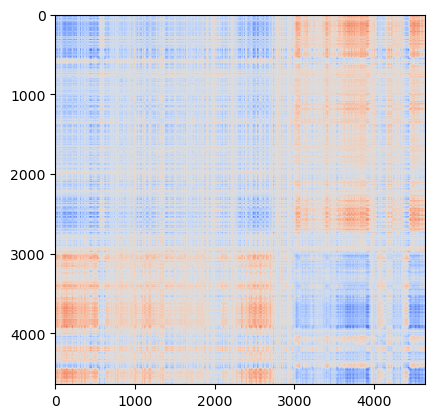

In [69]:
# Construct restaurants similarity matrix by normalize meta-data features
scaler = StandardScaler()
df_restaurants_norm = scaler.fit_transform(df_restaurants.iloc[:, 1:])

similarity_mtx_feat = pairwise_distances(df_restaurants_norm, metric='cosine')
print(similarity_mtx_feat.shape) #similarity between restaurants
plt.imshow(similarity_mtx_feat, cmap = 'coolwarm')

In [73]:
predicted_ratings_matrix_feat = pred_ratings(similarity_mtx_feat, train_set)
rmse_feat = compute_rmse(utility, predicted_ratings_matrix_feat)
print("RMSE:", rmse_feat)

RMSE: 0.5989196014127578


### 4.2.2 Restaurant Similarities by User Ratings

In [71]:
distance_mtx_train = squareform(pdist(train_set, 'cosine'))
similarity_mtx_train = 1- distance_mtx_train
print(similarity_mtx_train.shape) #similarity between restaurants

(4638, 4638)


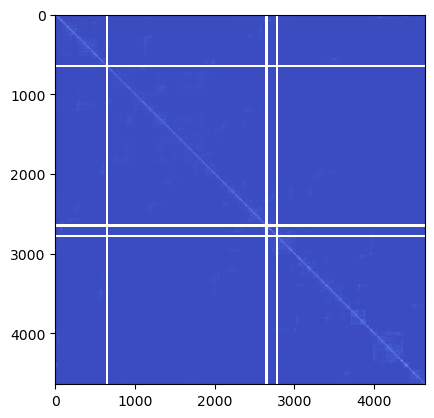

In [72]:
plt.imshow(similarity_mtx_train, cmap = 'coolwarm')

In [22]:
predicted_ratings_matrix_train = pred_ratings(similarity_mtx_train, train_set)
rmse_train = compute_rmse(utility, predicted_ratings_matrix_train)
print("RMSE:", rmse_train)

RMSE: 0.6123975432937754


### 4.2.3 User Similarities by Review Text Embeddings

In [45]:
import importlib
import utility as util
importlib.reload(utility)

import numpy as np
import pandas as pd
from utility import get_similar_users_avg_rating

RERUN_EMBED = False

In [26]:
user_df = pd.read_csv('data/user_concat_text_10_20.csv', sep=';')

In [53]:
#recommend by matrix factorization: 1 restaurant, similar users
def calculate_restaurant_rating(gmapid, similarity_mtx, train_set):
    rest_rating = train_set.loc[gmapid,:]
    pred_rating = deepcopy(rest_rating)
    
    default_rating = rest_rating[rest_rating>0].mean()
    numerate = np.dot(similarity_mtx, rest_rating)
    corr_sim = similarity_mtx[:, rest_rating >0]
    for i,ix in enumerate(pred_rating):
        temp = 0
        if ix < 1:
            w_r = numerate[i]
            sum_w = corr_sim[i,:].sum()
            if w_r == 0 or sum_w == 0:
                temp = default_rating
            else:
                temp = w_r / sum_w
            pred_rating.iloc[i] = temp
    return pred_rating
# apply calculate_restaurant_rating to all restaurants
def pred_ratings_rest(similarity_mtx, train_set):
    rest_ids = df_cleaned['gmap_id'].unique()

    # Initialize an empty DataFrame to store predicted ratings for all user-restaurant pairs
    predicted_ratings_matrix = pd.DataFrame(index=utility.index, columns=utility.columns)

    for gmap_id in rest_ids:
        predicted_ratings = calculate_restaurant_rating(gmap_id, similarity_mtx, train_set)
        predicted_ratings_matrix.loc[gmap_id] = predicted_ratings
        
    return predicted_ratings_matrix

#### 4.2.3.1 Word2Vec

In [38]:
import gensim.downloader as api
import nltk
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
import string

In [30]:
nltk.download('punkt')

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # Join the tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

[nltk_data] Downloading package punkt to /Users/mashiyu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
text_df = pd.read_csv('data/user_concat_text_10_20.csv', sep=';')
text_df['text_after'] = text_df['text'].apply(preprocess_text)
text_df['text_split'] = text_df['text_after'].apply(lambda x: x.split())
text_df

,user_id,text,text_after,text_split
0,1.000018e+20,Great food. The service was a little slow. It ...,great food the service was a little slow it wa...,"[great, food, the, service, was, a, little, sl..."
1,1.000020e+20,I like the variety of burgers they offer. But ...,i like the variety of burgers they offer but i...,"[i, like, the, variety, of, burgers, they, off..."
2,1.000027e+20,Margarita was yummy. Food not great.\nCrazy No...,margarita was yummy food not great crazy noodl...,"[margarita, was, yummy, food, not, great, craz..."
3,1.000030e+20,Very good food a little pricey but worth every...,very good food a little pricey but worth every...,"[very, good, food, a, little, pricey, but, wor..."
4,1.000057e+20,Delightful and charming place to dine outside....,delightful and charming place to dine outside ...,"[delightful, and, charming, place, to, dine, o..."
...,...,...,...,...
10980,1.184382e+20,Nice little place in Sudbury.Good prices and g...,nice little place in sudbury.good prices and g...,"[nice, little, place, in, sudbury.good, prices..."
10981,1.184401e+20,Over the phone order takes forever.\nReception...,over the phone order takes forever receptionis...,"[over, the, phone, order, takes, forever, rece..."
10982,1.184433e+20,Was great food and service\nA little pricey fo...,was great food and service a little pricey for...,"[was, great, food, and, service, a, little, pr..."
10983,1.184449e+20,Only came because we had a gift card. Reminded...,only came because we had a gift card reminded ...,"[only, came, because, we, had, a, gift, card, ..."


In [33]:
# Load Pretrained Word2Vec Embeddings
pretrained_model = api.load('fasttext-wiki-news-subwords-300')
pretrained_model.save_word2vec_format('data/pretrained')

In [34]:
# Fine-Tuning
my_model = Word2Vec(vector_size=300, min_count=1)
my_model.build_vocab(text_df['text_split'])

my_model.wv.vectors_lockf = np.ones(len(my_model.wv))

my_model.wv.intersect_word2vec_format('data/pretrained', lockf=1.0)
my_model.train(text_df['text_split'], total_examples=my_model.corpus_count, epochs=5)

(17843513, 24273725)

In [35]:
# Compare word embeddings before and after fine-tuning
print('Vocabulary Size before and after fine-tuning: ', len(my_model.wv.index_to_key), len(pretrained_model.index_to_key))
common_vocab = set(my_model.wv.index_to_key).intersection(set(pretrained_model.index_to_key))
vectors1 = [my_model.wv[word] for word in common_vocab]
vectors2 = [pretrained_model[word] for word in common_vocab]

# Compute the cosine similarity between pretrained and final embedding after fine-tuning
similarity_matrix = cosine_similarity(vectors1, vectors2)
print('Cosine Similarity before and after fine-tuning: ', np.mean(np.diag(similarity_matrix)))

Vocabulary Size before and after fine-tuning:  58502 999999


Cosine Similarity before and after fine-tuning:  0.8631006


In [37]:
# Combine word embeddings for each user

sentence_vectors = []
for user in text_df['text_split']:
    # Get word vectors and filter out unknown words
    word_vectors = [my_model.wv[word] for word in user if word in my_model.wv]

    # Average word vectors to get sentence vector
    if word_vectors:
        sentence_vector = np.mean(word_vectors, axis=0)
        sentence_vectors.append(sentence_vector)
text_df['word2vec_embed'] = sentence_vectors
text_df

,user_id,text,text_after,text_split,word2vec_embed
0,1.000018e+20,Great food. The service was a little slow. It ...,great food the service was a little slow it wa...,"[great, food, the, service, was, a, little, sl...","[-0.017623516, 0.20048387, -0.27110398, -0.089..."
1,1.000020e+20,I like the variety of burgers they offer. But ...,i like the variety of burgers they offer but i...,"[i, like, the, variety, of, burgers, they, off...","[0.045501992, 0.16939767, -0.19926833, -0.0603..."
2,1.000027e+20,Margarita was yummy. Food not great.\nCrazy No...,margarita was yummy food not great crazy noodl...,"[margarita, was, yummy, food, not, great, craz...","[0.012545273, 0.20921554, -0.19771455, -0.0093..."
3,1.000030e+20,Very good food a little pricey but worth every...,very good food a little pricey but worth every...,"[very, good, food, a, little, pricey, but, wor...","[0.07836086, 0.18731324, -0.17917225, -0.10264..."
4,1.000057e+20,Delightful and charming place to dine outside....,delightful and charming place to dine outside ...,"[delightful, and, charming, place, to, dine, o...","[0.07148495, 0.1686458, -0.22700404, -0.077255..."
...,...,...,...,...,...
10980,1.184382e+20,Nice little place in Sudbury.Good prices and g...,nice little place in sudbury.good prices and g...,"[nice, little, place, in, sudbury.good, prices...","[0.06826867, 0.2595536, -0.18338573, -0.309849..."
10981,1.184401e+20,Over the phone order takes forever.\nReception...,over the phone order takes forever receptionis...,"[over, the, phone, order, takes, forever, rece...","[0.05983279, 0.21895027, -0.2568223, -0.079261..."
10982,1.184433e+20,Was great food and service\nA little pricey fo...,was great food and service a little pricey for...,"[was, great, food, and, service, a, little, pr...","[0.08583503, 0.10749796, -0.26361787, -0.11668..."
10983,1.184449e+20,Only came because we had a gift card. Reminded...,only came because we had a gift card reminded ...,"[only, came, because, we, had, a, gift, card, ...","[0.05903778, 0.19704708, -0.25881737, -0.04174..."


In [39]:
similarity_mtx_user_f = pairwise_distances(text_df['word2vec_embed'].tolist(), metric='cosine')
print(similarity_mtx_user_f.shape) #similarity between users

(10985, 10985)


In [76]:
predicted_ratings_matrix_user_f = pred_ratings_rest(similarity_mtx_user_f, train_set)
rmse_user_f = compute_rmse(utility, predicted_ratings_matrix_user_f)
print("RMSE:", rmse_user_f)

RMSE: 0.5862129506477894


#### 4.2.3.2 Bag of Words

In [ ]:
if RERUN_EMBED:
    from sklearn.feature_extraction.text import CountVectorizer
    from nltk.corpus import words
    from sklearn.decomposition import PCA

    concatenated_comments = user_df.copy()
    # create the vocabulary, remove stop words
    vectorizer = CountVectorizer(stop_words='english')

    # fit the vocabulary to the text data and create the bag-of-words model
    bow_model = vectorizer.fit_transform(concatenated_comments["text"])
    bow_df = pd.DataFrame(bow_model.toarray(), columns=vectorizer.get_feature_names_out())

    # Download the set of English words from nltk
    nltk.download('words')
    english_words = set(words.words())

    # remove non-English words
    english_idx = pd.Series(bow_df.columns.values).apply(lambda x : x in english_words)
    bow_df = bow_df[bow_df.columns[english_idx]].astype(int)

    # Perform PCA
    pca = PCA(.8)
    pca.fit(bow_df)

    # Plot Variance Explained
    exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(8, 5))
    plt.fill_between(range(1, exp_var_cumul.shape[0] + 1), exp_var_cumul, color="blue", alpha=0.4)
    plt.plot(range(1, exp_var_cumul.shape[0] + 1), exp_var_cumul, color="blue", alpha=0.6) 
    plt.title('Cumulative Explained Variance as a Function of the Number of Components')
    plt.xlabel('# Components')
    plt.ylabel('Explained Variance')
    plt.grid(True)

    # Embeddings After PCA
    bow_embedding = pd.DataFrame(bow_df_pca).apply(lambda row: row.tolist(), axis=1)
    bow_embedding_df = pd.concat([concatenated_comments, pd.DataFrame(bow_embedding)], axis = 1)
    bow_embedding_df.columns.values[2] = "BOW_embedding"

    bow_embedding_df.to_csv("data/user_concat_text_10_20_BOW.csv", sep=';', index=False)

    

In [77]:
BOW_df = pd.read_csv("data/user_concat_text_10_20_BOW.csv", sep = ";")
BOW_df

,user_id,text,BOW_embedding
0,1.000018e+20,Great food. The service was a little slow. It ...,"[-1.3322251176642164, 2.273819685005117, 1.985..."
1,1.000020e+20,I like the variety of burgers they offer. But ...,"[10.29148731742613, -4.420930268859397, -8.567..."
2,1.000027e+20,Margarita was yummy. Food not great.\nCrazy No...,"[-2.6008537544142865, 2.370196191927631, -3.57..."
3,1.000030e+20,Very good food a little pricey but worth every...,"[-1.9098802955132501, -2.9086978874441494, 0.5..."
4,1.000057e+20,Delightful and charming place to dine outside....,"[22.516289847034443, -2.740338698802675, -3.16..."
...,...,...,...
10980,1.184382e+20,Nice little place in Sudbury.Good prices and g...,"[-1.7003215671263872, -4.319781758397664, 8.42..."
10981,1.184401e+20,Over the phone order takes forever.\nReception...,"[-4.870188645033443, -0.7836920965320646, -4.1..."
10982,1.184433e+20,Was great food and service\nA little pricey fo...,"[10.952753305704062, 6.3846210005718556, 4.934..."
10983,1.184449e+20,Only came because we had a gift card. Reminded...,"[-9.209499269584088, -1.6524134964014876, -1.8..."


In [83]:
import ast
BOW_df['BOW_embedding'] = BOW_df['BOW_embedding'].apply(lambda x: [float(num) for num in ast.literal_eval(x)])
similarity_mtx_user_bow = pairwise_distances(BOW_df['BOW_embedding'].tolist(), metric='cosine')
print(similarity_mtx_user_bow.shape) #similarity between users

(10985, 10985)


In [84]:
predicted_ratings_matrix_user_bow = pred_ratings_rest(similarity_mtx_user_bow, train_set)
rmse_user_bow = compute_rmse(utility, predicted_ratings_matrix_user_bow)
print("RMSE:", rmse_user_bow)

RMSE: 0.5777252414737728


#### 4.2.3.3 Latent Dirichlet Allocation (LDA)

##### Preprocessing Text before Using TF-IDF Vectorizer

In [ ]:
user_reviews_df = pd.read_csv('data/user_concat_text_10_20.csv', sep=';')
user_reviews_df.head()

,user_id,text
0,1.000018e+20,Great food. The service was a little slow. It ...
1,1.000020e+20,We had a large party but they accommodated us ...
2,1.000027e+20,Margarita was yummy. Food not great.\nWe love ...
3,1.000030e+20,I eat there when I have a chance to do it I ha...
4,1.000057e+20,Drinks desert and Jarvis tops off a good eveni...


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Download necessary NLTK resources
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Initialize tokenizer, lemmatizer, and stopwords
tokenizer = RegexpTokenizer(r'\w+')
lemmer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocess and tokenize function
def preprocess_tokenize_text(text):
    # Remove non-relevant words
    text = re.sub(r'\(Original\)', '', text)
    text = re.sub(r'\(Translated by Google\)', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokens = tokenizer.tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    tokens = [lemmer.lemmatize(w) for w in tokens]

    # Remove single letter tokens
    tokens = [w for w in tokens if len(w) > 1]

    # Join tokens back to a single string
    return ' '.join(tokens)

In [ ]:
user_reviews_df['processed_text'] = user_reviews_df['text'].apply(preprocess_tokenize_text)
user_reviews_df.head()

,user_id,text,processed_text
0,1.000018e+20,Great food. The service was a little slow. It ...,great food service little slow nice clean food...
1,1.000020e+20,We had a large party but they accommodated us ...,large party accommodated could watch patriot g...
2,1.000027e+20,Margarita was yummy. Food not great.\nWe love ...,margarita yummy food great love tasty burger w...
3,1.000030e+20,I eat there when I have a chance to do it I ha...,eat chance going since kid go area love food w...
4,1.000057e+20,Drinks desert and Jarvis tops off a good eveni...,drink desert jarvis top good evening tewkesbur...


##### Train a LDA Model and vectorize documents

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000)

# Vectorize the processed text
X = vectorizer.fit_transform(user_reviews_df['processed_text'])

# Initialize LDA Model
n_topics = 15
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)

# Train LDA model
lda.fit(X)



# Add topic distribution vectors to DataFrame
topic_distributions = lda.transform(X)
user_reviews_df['topic_vector'] = list(topic_distributions)

user_reviews_df.head()

,user_id,text,processed_text,topic_vector
0,1.000018e+20,Great food. The service was a little slow. It ...,great food service little slow nice clean food...,"[0.009604099033542457, 0.009604097040164497, 0..."
1,1.000020e+20,We had a large party but they accommodated us ...,large party accommodated could watch patriot g...,"[0.9332929748068605, 0.004764784389977953, 0.0..."
2,1.000027e+20,Margarita was yummy. Food not great.\nWe love ...,margarita yummy food great love tasty burger w...,"[0.0068352206810172785, 0.00683521500500783, 0..."
3,1.000030e+20,I eat there when I have a chance to do it I ha...,eat chance going since kid go area love food w...,"[0.011245047569970199, 0.011245043923995425, 0..."
4,1.000057e+20,Drinks desert and Jarvis tops off a good eveni...,drink desert jarvis top good evening tewkesbur...,"[0.005380025279412345, 0.005380015639471415, 0..."


##### Visualize The topics

In [ ]:
!pip install pyldavis

In [ ]:

import pyLDAvis
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()
lda_display = pyLDAvis.lda_model.prepare(lda, X, vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Here we visualize the topics. We can tell that although some topics overlap with each other quite a lot, some other topics have good separations, forming 4 main clusters. If we inspect the top salient terms, we can tell that it seems like while the center cluster seems to be related to general positive terms for a restruant, the left cluster seems to related more about types of food.

In [ ]:
user_reviews_df.to_csv("data/user_reviews_lda_df.csv", index=False)

In [86]:
LDA_df = pd.read_csv("data/user_concat_text_10_20_LDA.csv")
LDA_df

,user_id,text,processed_text,topic_vector
0,1.000018e+20,Great food. The service was a little slow. It ...,great food service little slow nice clean food...,"[0.008479388512816176, 0.008479365815023726, 0..."
1,1.000020e+20,I like the variety of burgers they offer. But ...,like variety burger offer also love plain chee...,"[0.004407226022489952, 0.004407213121123108, 0..."
2,1.000027e+20,Margarita was yummy. Food not great.\nCrazy No...,margarita yummy food great crazy noodle die ev...,"[0.006100017629404393, 0.006100000918001957, 0..."
3,1.000030e+20,Very good food a little pricey but worth every...,good food little pricey worth every penny like...,"[0.009779435632885775, 0.009779412004167725, 0..."
4,1.000057e+20,Delightful and charming place to dine outside....,delightful charming place dine outside table l...,"[0.004582977826246413, 0.004582961469127031, 0..."
...,...,...,...,...
10980,1.184382e+20,Nice little place in Sudbury.Good prices and g...,nice little place sudburygood price good food ...,"[0.01163532544199986, 0.011635280277155097, 0...."
10981,1.184401e+20,Over the phone order takes forever.\nReception...,phone order take forever receptionist guy saw ...,"[0.006310960434835849, 0.006310943316822855, 0..."
10982,1.184433e+20,Was great food and service\nA little pricey fo...,great food service little pricey lowell qualit...,"[0.007378448530855325, 0.007378423666287232, 0..."
10983,1.184449e+20,Only came because we had a gift card. Reminded...,came gift card reminded dont go kind place any...,"[0.9051477858387621, 0.006775147544525782, 0.0..."


In [88]:
LDA_df['topic_vector'] = LDA_df['topic_vector'].apply(lambda x: [float(num) for num in ast.literal_eval(x)])
similarity_mtx_user_lda = pairwise_distances(LDA_df['topic_vector'].tolist(), metric='cosine')
print(similarity_mtx_user_lda.shape) #similarity between users

(10985, 10985)


In [89]:
predicted_ratings_matrix_user_lda = pred_ratings_rest(similarity_mtx_user_lda, train_set)
rmse_user_lda = compute_rmse(utility, predicted_ratings_matrix_user_lda)
print("RMSE:", rmse_user_lda)

RMSE: 0.5899411407313644


#### 4.2.3.4 Large Language Model (BERT)

In [25]:
if RERUN_EMBED:
    import torch
    from transformers import BertModel, BertTokenizer

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def generate_embedding(input_text):
        # Tokenize input text
        input_ids = tokenizer.encode_plus(input_text, 
                                        add_special_tokens=True, 
                                        return_tensors="pt", 
                                        truncation=True,
                                        max_length=512,
                                        padding='max_length')  # Adjust max_length
        input_ids = input_ids.to(device)
        with torch.no_grad():
            model.to(device)
            outputs = model(**input_ids)  # Pass the tokenized inputs as keyword arguments
            embeddings =outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
        return embeddings
    
    user_df['bert_embedding'] = user_df['text'].apply(generate_embedding)
    user_df['bert_embedding'] = user_df['bert_embedding'].apply(lambda x: x.to('cpu').numpy() if isinstance(x, torch.Tensor) else x)
    user_df['bert_embedding'] = user_df['bert_embedding'].apply(lambda x: x.reshape(-1,))
    user_df.to_csv('data/user_concat_text_10_20_bert.csv', sep=';', index=False)

In [90]:
BERT_df = pd.read_csv("data/user_concat_text_10_20_bert.csv", sep = ";")
BERT_df

,user_id,text,bert_embedding
0,1.000018e+20,Great food. The service was a little slow. It ...,[-2.28271410e-01 -3.50522280e-01 5.03636479e-...
1,1.000020e+20,I like the variety of burgers they offer. But ...,[ 5.88846840e-02 -2.44759530e-01 4.13423270e-...
2,1.000027e+20,Margarita was yummy. Food not great.\nCrazy No...,[-4.27331746e-01 -3.91346186e-01 4.74730760e-...
3,1.000030e+20,Very good food a little pricey but worth every...,[-1.57243684e-01 1.72801331e-01 2.56079763e-...
4,1.000057e+20,Delightful and charming place to dine outside....,[-3.10034573e-01 -2.72774488e-01 6.97727799e-...
...,...,...,...
10980,1.184382e+20,Nice little place in Sudbury.Good prices and g...,[-1.65720403e-01 3.92895013e-01 3.45245749e-...
10981,1.184401e+20,Over the phone order takes forever.\nReception...,[ 4.84165661e-02 -5.47631741e-01 5.35180688e-...
10982,1.184433e+20,Was great food and service\nA little pricey fo...,[ 3.24404538e-02 1.76963270e-01 6.72169149e-...
10983,1.184449e+20,Only came because we had a gift card. Reminded...,[-5.47769293e-02 -1.86119050e-01 3.32484752e-...


In [92]:
np.fromstring(string_array, sep=' ')
BERT_df['bert_embedding'][0]

'[-2.28271410e-01 -3.50522280e-01  5.03636479e-01  2.80287284e-02\n -2.26474881e-01  1.02521941e-01  4.67535138e-01  1.09784007e+00\n -6.34868443e-02 -8.11731517e-01  4.38435614e-01 -2.55993959e-02\n  4.93301272e-01  5.36774039e-01  4.02698107e-03  5.94971716e-01\n  1.24632113e-01  2.70881623e-01 -5.60337305e-02  1.88843962e-02\n  2.39957288e-01 -5.92766643e-01  4.58604485e-01 -3.18456888e-02\n -2.01717868e-01 -5.44000305e-02 -4.52559412e-01 -1.49405912e-01\n  1.35606840e-01  4.10244644e-01 -5.61850481e-02  3.01564932e-01\n -4.15155679e-01 -1.90660715e-01  3.26631695e-01 -6.38559639e-01\n  1.20516621e-01  3.18984121e-01  2.62044873e-02 -1.59103721e-01\n -2.47033283e-01  2.21067548e-01  2.94518322e-01 -2.32489496e-01\n -2.76781201e-01  7.76879609e-01 -4.53650427e+00  1.07470714e-02\n -1.45175502e-01 -2.90124714e-01 -9.36193243e-02 -3.45890433e-01\n -1.12833835e-01  3.83066565e-01  6.73724115e-01  4.81786191e-01\n -7.46391773e-01 -9.73462835e-02 -1.83761612e-01 -1.09773837e-01\n  5.80938

In [91]:
BERT_df['bert_embedding'].apply(lambda x: [float(num) for num in ast.literal_eval(x)])

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)

In [ ]:
similarity_mtx_user_bert = pairwise_distances(BERT_df['topic_vector'].tolist(), metric='cosine')
print(similarity_mtx_user_bert.shape) #similarity between users

In [ ]:
predicted_ratings_matrix_user_bert = pred_ratings_rest(similarity_mtx_user_bert, train_set)
rmse_user_bert = compute_rmse(utility, predicted_ratings_matrix_user_bert)
print("RMSE:", rmse_user_bert)

In [60]:
if RERUN_EMBED:
    df_cleaned['bert_rating'] = df_cleaned.progress_apply(lambda row: get_similar_users_avg_rating(
            user_df, df_filtered, row['user_id'], row['gmap_id'],
            embedding='bert_embedding'
        ), axis=1)
    # Replace None with pd.nan in 'bert_rating' column
    df_cleaned['bert_rating'].replace({None: np.nan}, inplace=True)

Computing bert_ratings: 100%|██████████| 174568/174568 [1:17:40<00:00, 37.45it/s]
/var/folders/wh/3zjhqx7s7d747p205gcyh2480000gn/T/ipykernel_29930/3597421792.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['bert_rating'].replace({None: np.nan}, inplace=True)


In [61]:
BERT_pred_top10 = pd.read_csv("data/df_cleaned_bert.csv", sep = ";")
BERT_pred_top10

#### 4.2.3.4 Large Language Model (Fined-tuned Sentence Transformer)

We opted to fine-tune a pretrained sentence transformer model from HuggingFace for our recommendation system. Sentence Transformer, or Sentence-BERT (SBERT) is a modification of the pretrained BERT network that use siamese and triplet network structures to derive semantically meaningful sentence embeddings that can be compared using cosine-similarity. This reduces the effort for finding the most similar pair from 65 hours with BERT / RoBERTa to about 5 seconds with SBERT, while maintaining the accuracy from BERT. The architecture of the Sentence Transformer efficiently maps sentences and paragraphs to a 384-dimensional dense vector space. This capability is particularly useful for applications such as clustering or semantic search. In the context of our project, this model serves as a powerful tool for analyzing and understanding user-generated review texts at our platform. By embedding these reviews into a dense vector space, we can accurately measure semantic similarities between different texts. This approach enables us to identify users with similar preferences and tastes based on their review content. Consequently, this similarity assessment facilitates the construction of a more personalized and effective recommendation system for restaurants, as users who express similar sentiments in their reviews are likely to appreciate similar dining experiences. This tailored recommendation system not only enhances user satisfaction but also improves engagement by connecting users more effectively with restaurants that match their preferences.


In [ ]:
user_df = pd.read_csv('data/user_concat_text_10_20.csv',sep=';')
user_df.head()

,user_id,text
0,1.000018e+20,Great food. The service was a little slow. It ...
1,1.000020e+20,I like the variety of burgers they offer. But ...
2,1.000027e+20,Margarita was yummy. Food not great.\nCrazy No...
3,1.000030e+20,Very good food a little pricey but worth every...
4,1.000057e+20,Delightful and charming place to dine outside....


##### Prepare Data for Fine Tuning

In [ ]:
cleaned_df = pd.read_csv('data/cleaned_df.csv')
cleaned_df = cleaned_df.dropna()
cleaned_df = cleaned_df[~cleaned_df['price'].isin(['₩₩', '₩', '₩₩₩₩', '₩₩₩'])]
cleaned_df  = cleaned_df[['user_id','gmap_id', 'text', 'rating' ]]
cleaned_df


,user_id,gmap_id,text,rating
0,1.182288e+20,0x89e4f921a38f0b11:0x879ccb1d12f010de,Love the chicken sandwiches but the service ne...,3
1,1.090050e+20,0x89e4f921a38f0b11:0x879ccb1d12f010de,The place was super smokey when we came in whi...,3
2,1.128417e+20,0x89e4f921a38f0b11:0x879ccb1d12f010de,"While I love all their chicken offerings, my w...",5
3,1.175200e+20,0x89e4f921a38f0b11:0x879ccb1d12f010de,Always the best fried chicken around. Mash pot...,5
4,1.130399e+20,0x89e4f921a38f0b11:0x879ccb1d12f010de,Awesome chicken crisp not greasy!,5
...,...,...,...,...
93046,1.178104e+20,0x89e379f5e3d9fe1b:0xa265a864b0f05b6a,Grab the starving student deal!,5
93047,1.172052e+20,0x89e379f5e3d9fe1b:0xa265a864b0f05b6a,Love the burgers here.,5
93048,1.145775e+20,0x89e379f5e3d9fe1b:0xa265a864b0f05b6a,Best burger in Boston by far.,5
93049,1.157460e+20,0x89e379f5e3d9fe1b:0xa265a864b0f05b6a,Best fast burgers around especially late at night,5


##### Fine Tuning Sentence Transformer

We fine-tuned the pretrained sentence transformer through the text classification task: we will let model classify the review text into 5 categories representing ratings (between 1 through 5).

In [ ]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

# Prepare data
texts = cleaned_df['text'].tolist()
ratings = cleaned_df['rating'].apply(lambda x: x - 1).tolist()  # zero-indexed

# Tokenize data
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, ratings, test_size=0.2, random_state=42)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='tf')
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors='tf')

# Convert to tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(1000).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(32)


In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    'sentence-transformers/all-MiniLM-L6-v2', 
    num_labels=len(set(ratings))  # Assuming ratings are 0-indexed and continuous
)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Model summary
model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  22713216  
                                                                 
 dropout_39 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1925      
                                                                 
Total params: 22715141 (86.65 MB)
Trainable params: 22715141 (86.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=3, 
    restore_best_weights=True
)

history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=10, 
    callbacks=[early_stopping]
)


Epoch 1/10


2024-05-08 17:47:17.027984: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f71e9474c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-08 17:47:17.028024: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-05-08 17:47:17.035703: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-08 17:47:17.056568: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1715190437.159292     560 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1385/1385 [==============================] - 1265s 897ms/step - loss: 0.8645 - accuracy: 0.6236 - val_loss: 0.7832 - val_accuracy: 0.6621
Epoch 2/10
1385/1385 [==============================] - 1239s 894ms/step - loss: 0.7509 - accuracy: 0.6719 - val_loss: 0.7807 - val_accuracy: 0.6615
Epoch 3/10
1385/1385 [==============================] - 1238s 894ms/step - loss: 0.6844 - accuracy: 0.7035 - val_loss: 0.8080 - val_accuracy: 0.6554
Epoch 4/10
1385/1385 [==============================] - 1238s 894ms/step - loss: 0.6119 - accuracy: 0.7409 - val_loss: 0.8573 - val_accuracy: 0.6444


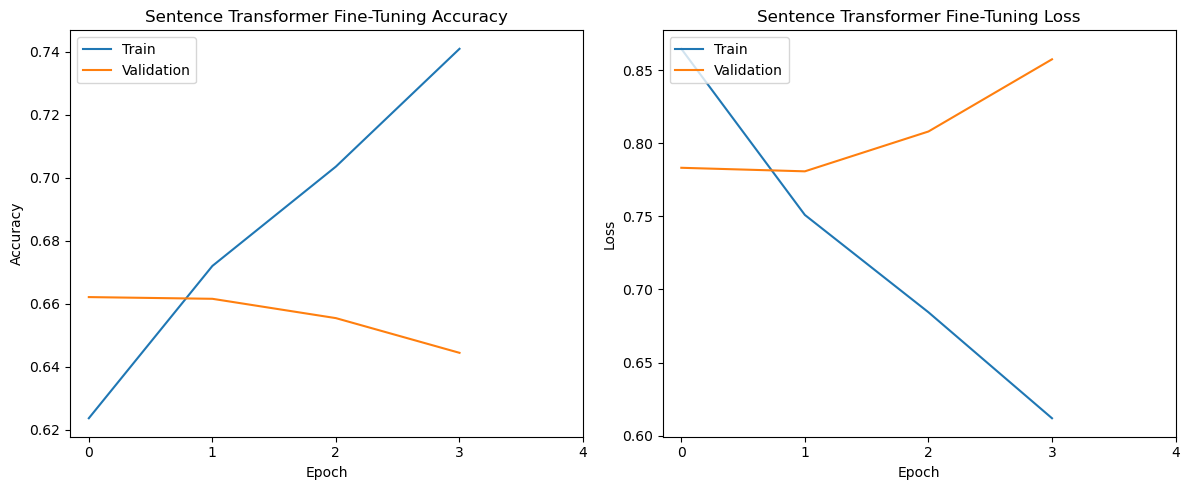

In [ ]:


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Sentence Transformer Fine-Tuning Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks([0, 1, 2, 3, 4])  # Set x-axis ticks to start at 1

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Sentence Transformer Fine-Tuning Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks([0, 1, 2, 3, 4])  # Set x-axis ticks to start at 1

plt.tight_layout()
plt.show()


We've tried using different learning rate/optimizers/batch size/max length for tokenizer. It turns out that for most of the times the model reaches best performance within 2-3 epochs. We've used early stopping callback to prevent overfitting and restore the best weights. For the final model used for inference, we were able to achive final validation accuracy of around 0.72 and final validation loss around 0.68.
Above we present the training history curve for one of the training we performed. We can trail that the it has best validation accuracy at the first epoch and best validation loss at the secend epoch. 

In [ ]:
model.save_pretrained('./sentence_tf')


##### Get Embeddings For User Review Texts Using Fine-Tuned Model

In [ ]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')


In [ ]:

texts = user_df['text'].tolist()

# Tokenize the texts
encodings = tokenizer(texts, truncation=True, padding=True, return_tensors='tf', max_length = 128)

# Create a dataset from the encodings
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': encodings['input_ids'], 
        'attention_mask': encodings['attention_mask']
    }
)).batch(32)  # Use an appropriate batch size

model = TFAutoModel.from_pretrained('./sentence_tf', output_hidden_states=True)

# Set the model to evaluation mode
model.trainable = False
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state  # [batch_size, seq_length, hidden_size]
    input_mask_expanded = tf.cast(attention_mask[:, :, tf.newaxis], tf.float32)  # expand dims for broadcasting
    sum_embeddings = tf.reduce_sum(token_embeddings * input_mask_expanded, axis=1)  # sum over seq_length
    sum_mask = tf.reduce_sum(input_mask_expanded, axis=1)  # sum over seq_length
    return sum_embeddings / sum_mask  # [batch_size, hidden_size]
def generate_embeddings(dataset):
    all_embeddings = []
    for batch in dataset:
        outputs = model(batch)
        batch_embeddings = mean_pooling(outputs, batch['attention_mask'])
        normalized_embeddings = tf.nn.l2_normalize(batch_embeddings, axis=1)
        all_embeddings.append(normalized_embeddings)
    
    return tf.concat(all_embeddings, axis=0)

embeddings = generate_embeddings(dataset)




All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ./sentence_tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Convert TensorFlow tensor to list for DataFrame compatibility
embeddings_list = embeddings.numpy().tolist()
user_df['embeddings'] = embeddings_list



In [ ]:
user_df

,user_id,text,embeddings
0,1.000018e+20,Great food. The service was a little slow. It ...,"[-0.0056116883642971516, 0.022179247811436653,..."
1,1.000020e+20,I like the variety of burgers they offer. But ...,"[-0.00281165586784482, -0.026171637699007988, ..."
2,1.000027e+20,Margarita was yummy. Food not great.\nCrazy No...,"[-0.006889836862683296, 0.03644988313317299, 0..."
3,1.000030e+20,Very good food a little pricey but worth every...,"[0.02222825400531292, -0.008512366563081741, 0..."
4,1.000057e+20,Delightful and charming place to dine outside....,"[0.07434279471635818, -0.0028389240615069866, ..."
...,...,...,...
10980,1.184382e+20,Nice little place in Sudbury.Good prices and g...,"[0.025149960070848465, 0.0038889821153134108, ..."
10981,1.184401e+20,Over the phone order takes forever.\nReception...,"[-0.036308806389570236, 0.005466552916914225, ..."
10982,1.184433e+20,Was great food and service\nA little pricey fo...,"[-0.0015855561941862106, -0.004658845718950033..."
10983,1.184449e+20,Only came because we had a gift card. Reminded...,"[0.032650914043188095, 0.05890003219246864, 0...."


In [ ]:
user_df.to_csv("data/user_reviews_sententf_df.csv", index=False)

# 5. Results

# 6. Conclusion

# 7. Future Work